In [1]:
import torch
#  from NN_ANARX.NARX import NARX
from NN_ANARX.ANARX import ANARX
from NN_ANARX.ANARX_SS import ANARX_SS
import matplotlib.pyplot as plt
from tqdm import tqdm
from NN_ANARX.utilities import lag_matrix
import scipy.io
import numpy as np
import scipy.io

c:\Users\vh\Anaconda3\envs\PM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data and model loading and preparation
# the model has to be in SISO-SANARX Form
model = torch.load("models/siso-model.pt")
data = scipy.io.loadmat("data/1803")
input = data["u2_t"]
out = data["y_t"]

out = torch.Tensor(out).squeeze()
input = torch.Tensor(input).squeeze()
in_lagged = lag_matrix(input, 5)
out_lagged = lag_matrix(out, 14)

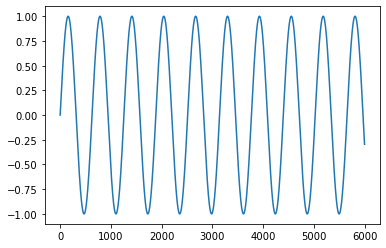

In [3]:
# create some test trajectories
sinewave = np.sin(np.arange(0, 60, 0.01))
step = np.concatenate((np.zeros(2000), .3*np.ones(2000), np.zeros(2000)))
plt.plot(sinewave)

Torch-Linear-Function:

$ \eta_1(t) = \left[u(t), y(t)\right]^T\cdot A^T + b $ or


$ u(t)\cdot a_1 + y(t) \cdot a_2 + b = \eta(t)$

$u(t)$ can be computed from desired trajectory $\eta(t)$:


$ u(t) = \dfrac{\eta(t)-y(t)\cdot a_2 - b}{a_1}$

In [4]:
# extract control parameters from Linear subnet
a1 = model.subnets[0].linear_layers[0].weight[0,0]
a2 = model.subnets[0].linear_layers[0].weight[0,1]
b = model.subnets[0].linear_layers[0].bias

In [5]:
# compute simulated output of NN-SANARX-Model in state-space-representation
# using computed-control-input to follow step-trajectory
controlled_input = torch.zeros_like(input)
x = torch.zeros(model.n_subnets).float()

modelss = ANARX_SS(model)
y = []
for i in tqdm(range(5999)):
    y.append(x[0].detach().numpy())
    controlled_input[i] = (step[i]-x[1] - torch.Tensor(x[0]) * a2 - b)/a1
    x = modelss(x, torch.unsqueeze(x[0], dim=0), torch.unsqueeze(controlled_input[i], dim=0))

100%|██████████| 5999/5999 [00:16<00:00, 362.37it/s]


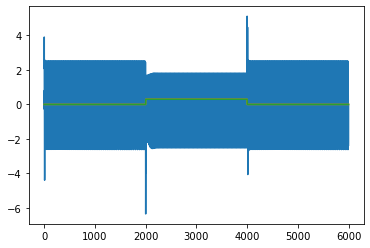

In [6]:
# compare model prediction to planned trajectory and controlled input
plt.plot(controlled_input.detach().numpy())
plt.plot(step)
plt.plot(y)


In [7]:
# compute simulated output of NN-SANARX-Model in state-space-representation
# using computed-control-input to follow step-trajectory
controlled_input = torch.zeros_like(input)
x = torch.zeros(model.n_subnets).float()

modelss = ANARX_SS(model)
y = []
for i in tqdm(range(5999)):
    y.append(x[0].detach().numpy())
    controlled_input[i] = (sinewave[i]-x[1] - torch.Tensor(x[0]) * a2 - b)/a1
    x = modelss(x, torch.unsqueeze(x[0], dim=0), torch.unsqueeze(controlled_input[i], dim=0))

100%|██████████| 5999/5999 [00:16<00:00, 368.04it/s]


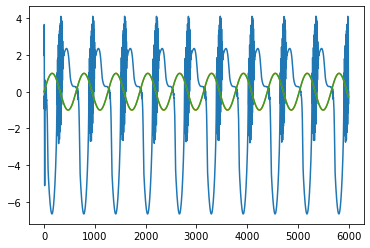

In [8]:
# compare model prediction to planned trajectory and controlled input
plt.plot(controlled_input.detach().numpy())
plt.plot(sinewave)
plt.plot(y)
